### PPO, Actor-Critic Style
_______________________
&nbsp;&nbsp;**for** iteration=1,2,... do<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**for** actor=1,2,...,N do<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Run policy $\pi_{\theta_{old}}$ in environment for T timesteps<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Compute advantage estimates $\hat{A}_1,\dots,\hat{A}_T$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**end for**<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Optimize surrogate(代理人) L wrt $\theta$,with $K$ epochs and minibatch size $M \leq NT$<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\theta_{old} \leftarrow \theta$<br>
&nbsp;&nbsp;**end for**
_______________________

### Loss Function L的数学公式为:
$$
L_t^{CLIP+VF+S}(\theta)=\hat{\mathbb{E}_t}[L_t^{CLIP}(\theta)-c_1L^{VF}_t(\theta)+c_2S[\pi_\theta](s_t)]
$$
其中，$L^{CLIP}(\theta)=\hat{\mathbb{E}_t}\big[min(r_t(\theta)\hat{A}_t,clip(r_t(\theta), 1-\epsilon,1+\epsilon)\hat{A}_t)\big]$, $r_t(\theta)=\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}$<br>
$L^{VF}_t=(V_\theta(s_t)-V_t^{targ})^2$ **critic loss**<br>
S 为奖励熵，保证足够多的探索(写A2C的时候已经OK)<br>
$c_1, c_2$为参数
#### $L^{CLIP}和r的关系如下(为了保证\pi_\theta和\pi_{\theta_{old}}的差值不会很大,满足TRPO中两者方差变化不大的要求)$：
<img src="../assets/PPO_CLIP.png">

### GAE(high-dimensional continuous control using Generalized Advantage Estimation)
We address the first challenge by using value functions to substantially reduce the variance of policy gradient estimates at the cost of some bias, with an exponentially-weighted estimator of the advantage function that is analogous to TD(λ). <br>

改进了advantage function的计算方式。将advantage function进行类似于TD(λ)的处理<br>

#### 推导过程
1. 原始的advantage function : $\delta^V_t=r_t+\gamma V(s_{t+1})−V(s_t)$
2. $在位置t时,其后k个 \delta 折扣相加$ : 
$$
\begin{aligned}
\hat{A}^{(1)}_t&:=\delta^V_t&&=-V(s_t)+r_t+\gamma V(s_{t+1}) \\
\hat{A}^{(2)}_t&:=\delta^V_t+\gamma \delta^V_{t+1}&&=-V(s_t)+r_t+\gamma r_{t+1}+\gamma ^2 V(s_{t+2}) \\
\hat{A}^{(3)}_t&:=\delta^V_t+\gamma \delta^V_{t+1}+\gamma^2 \delta^V_{t+2}&&=-V(s_t)+r_t+\gamma r_{t+1}+\gamma^2 r_{t+2}+\gamma ^3 V(s_{t+3}) \\
\hat{A}_t^{(k)}&:=\sum_{l=0}^{k=1}\gamma^l\delta_{t+l}^V&&=-V(s_t)+r_t+\gamma r_{t+1}+\dots+\gamma^{k-1}r_{t+k-1}+\gamma^kV(s_{t+k})
\end{aligned}
$$


3. $k \to \infty, \gamma^kV(s_{t+k})$会变得非常非常非常小，So :
$$
\hat{A}_t^{(\infty)}=\sum^\infty_{l=0}\gamma^l\delta_{t+l}^V=-V(s_t)+\sum^\infty_{l=0}\gamma^lr_{t+l}
$$
4. 所以，$t$ 时刻的GAE可推导为 :
$$
\begin{aligned}
\hat{A}_t^{GAE(\gamma, \lambda)}&:=(1-\lambda)\big(\hat{A}_t^{(1)}+\lambda\hat{A}_t^{(2)}+\lambda^2\hat{A}_t^{(3)}+\dots\big)\\
&=(1-\lambda)\big(\delta_t^V+\lambda(\delta_t^V+\gamma\delta_{t+1}^V)+\lambda^2(\delta_t^V+\gamma\delta_{t+1}^V+\gamma^2\delta_{t+2}^V)+\dots\big)\\
&=(1-\lambda)\big(\delta^V_t(1+\lambda+\lambda^2+\dots)+\gamma\delta^V_{t+1}(\lambda+\lambda^2+\lambda^3+\dots)+\gamma^2\delta^V_{t+2}(\lambda^2+\lambda^3+\lambda^4+\dots)+\dots\big)\\
&=(1-\lambda)\big(\delta^V_t\big(\frac{1}{1-\lambda}\big)+\gamma\delta^V_{t+1}\big(\frac{\lambda}{1-\lambda}\big)+\gamma^2\delta^V_{t+2}\big(\frac{\lambda^2}{1-\lambda}\big)+\dots\big)\\
&=\underbrace{\delta^V_t+\gamma\lambda\delta^V_{t+1}+(\gamma\lambda)^2\delta^V_{t+2}+\dots}_{此处计算时使用这个公式(迭代计算)}\\
&=\sum_{l=0}^\infty(\gamma\lambda)^l\delta^V_{t+l}
\end{aligned}
$$

### 使用高斯分布(正态分布)来实现随机性策略控制连续动作空间
1. 高斯分布有两个重要的变量一个是均值 $\mu$ ,另一个是方差 $\sigma$ 。$\mu$ 为高斯函数的对称轴，$\frac{1}{\sqrt{2\pi}\sigma}$ 为高斯函数的最高点。高斯函数的积分为1。所以我们可以使用它来进行连续动作的sample。方差 $\sigma$ 越大，分布越分散，方差 $\sigma$ 越小，分布越集中。
2. $\mu$ 的选择很好把控，经过tanh处理之后+简单的数学变换，使nn输出的 $\mu$ 在env规定的动作空间内就可以
3. $\sigma$ 的选择,使用softplus函数对sigma进行处理。softplus 公式为$f(x)=\frac{1}{\beta}log(1+exp(\beta x))$, softplus 是 ReLU 的平滑近似值版本
4. 高斯分布公式:
$$
f(x)=\frac{1}{\sqrt{2\pi}\sigma}exp\bigg(-\frac{(x-\mu)^2}{2\sigma^2}\bigg)
$$
5. 和确定性策略相比，需要考虑每个state采取每个动作的概率，计算量确实比较大。

### TRPO
简单理解为一次on-policy到off-policy的转换<br>
但是为了保证old_policy和new_policy之间方差相差不会太大<br>
$$
\begin{aligned}
E_{X \sim p}[f(x)] & \approx \frac{1}{N}\sum^N_{i=1}f(x^i)\\
&= \int f(x)p(x)dx=\int f(x)\frac{p(x)}{q(x)}q(x)dx=E_{x \sim q}[f(x)\frac{p(x)}{q(x)}]
\end{aligned}
$$
由此，在两者期望相同的情况下，论证方差是否相同
$$
\begin{aligned}
两者期望:\quad&\because E_{X \sim p}[f(x)]=E_{x \sim q}[f(x)\frac{p(x)}{q(x)}]\\
方差公式:\quad&\because VAR[X]=E[X^2]-(E[X])^2\\
x \sim p 方差:\quad&\therefore Var_{x \sim p}[f(x)]=\color{red}{E_{x\sim p}[f(x)^2]}-(E_{x\sim p}[f(x)])^2\\
x \sim q 方差:\quad&\therefore Var_{x \sim q}[f(x)\frac{p(x)}{q(x)}]=E_{x \sim q}\big[\big([f(x)\frac{p(x)}{q(x)}\big)^2\big]-\big(E_{x\sim q}\big[f(x)\frac{p(x)}{q(x)}\big]\big)^2\\
&=\color{red}{E_{x \sim q}\big[f(x)^2\frac{p(x)}{q(x)}\big]}-(E_{x \sim p}[f(x)])^2
\end{aligned}
$$

两者方差公式的差别在标红的位置，也就是说我们如果使两者$E_{x\sim p}[f(x)^2]$和$E_{x \sim q}\big[f(x)^2\frac{p(x)}{q(x)}\big]$的差值较小，那么我们所做的off-policy就是可行的<br>
由此，可直观的看出，我们要使p(x)和q(x)的相差较小。因此就有了PPO1中的所使用的$\beta KL(\theta,\theta')$和PPO2中的clip这些都是为了限制两者的范围在一个可接受的合适空间

In [1]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.distributions import Categorical
import torch.multiprocessing as mp
# from torch.utils.tensorboard import SummaryWriter
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
from statistics import mean
import pdb
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

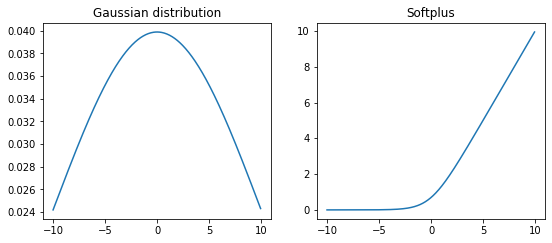

In [2]:
def plot_function():
    x = np.arange(-10,10,0.05)
    plt.figure(figsize=(9,3.6))

    plt.subplot(121)
    plt.title("Gaussian distribution")
    mu, sigma = 0, 10
    y = lambda x : np.exp(-((x-mu)**2)/(2*sigma**2))/(sigma*np.sqrt(2*np.pi))
    plt.plot(x, y(x))

    plt.subplot(122)
    plt.title("Softplus")
    y = np.log(1+np.exp(x))
    plt.plot(x, y)
    plt.show()

plot_function()

多线程又双叒叕来了

In [3]:
def worker(worker_id, master_end, worker_end, env_name):
    master_end.close()
    env = gym.make(env_name)
    env.seed(worker_id)
    
    while True:
        cmd, data = worker_end.recv()
        if cmd == 'step':
            state, reward, done, info = env.step(data)
            if done:
                state = env.reset()
            worker_end.send((state, reward, done, info))
        elif cmd == 'reset':
            state = env.reset()
            worker_end.send(state)
        elif cmd == 'reset_task':
            state = env.reset_task()
            worker_end.send(state)
        elif cmd == 'close':
            worker_end.close()
            break
        elif cmd == 'get_spaces':
            worker_end.send((env.observation_space.shape[0], env.action_space.shape[0]))
        else:
            raise NotImplementedError

In [4]:
class ParallelEnv:
    def __init__(self, n_train_processes, env_name):
        self.nenvs = n_train_processes
        self.waiting = False
        self.closed = False
        self.workers = []
        self.env_name = env_name
        
        self.master_ends, self.worker_ends = zip(*[mp.Pipe() for _ in range(self.nenvs)])
        
        for worker_id, (master_end, worker_end) in enumerate(zip(self.master_ends, self.worker_ends)):
            p = mp.Process(target=worker, args=(worker_id, master_end, worker_end, self.env_name))
            p.daemon = False
            p.start()
            self.workers.append(p)
        for worker_end in self.worker_ends:
            worker_end.close()
        
        self.master_ends[0].send(('get_spaces', None))
        self.observation_space, self.action_space = self.master_ends[0].recv()
        
    def step_async(self, actions):
        for master_end, action in zip(self.master_ends, actions):
            master_end.send(('step', action))
        self.waiting = True
    
    def step_wait(self):
        results = [master_end.recv() for master_end in self.master_ends]
        self.waiting = False
        states, rewards, dones, infos = zip(*results)
        return np.stack(states), np.stack(rewards), np.stack(dones), infos
    
    def reset(self):
        for master_end in self.master_ends:
            master_end.send(('reset', None))
        return np.stack([master_end.recv() for master_end in self.master_ends])
    
    def step(self, actions):
        self.step_async(actions)
        return self.step_wait()
    
    def close(self):
        if self.closed:
            return
        if self.waiting:
            [master_end.recv() for master_end in self.master_ends]
        for master_end in self.master_ends:
            master_end.send(('close', None))
        del self.workers[:]
        self.closed = True

定义网络

In [5]:
class Actor_critic(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(Actor_critic, self).__init__()
        self.actor_linear1 = nn.Linear(in_dim, 64)
        self.critic_linear1 = nn.Linear(in_dim, 64)
        self.linear2 = nn.Linear(64, 32)
        self.actor_linear3 = nn.Linear(32, out_dim)
        self.critic_linear3 = nn.Linear(32, 1)
        self.sigma_linear = nn.Linear(32, out_dim)
        
    def forward(self, x):
        value_hidden = F.relu(self.linear2(F.relu(self.critic_linear1(x))))
        value = self.critic_linear3(value_hidden)
        actor_hidden = F.relu(self.linear2(F.relu(self.actor_linear1(x))))
        mu = torch.tanh(self.actor_linear3(actor_hidden)) * 2
        sigma = F.softplus(self.sigma_linear(actor_hidden))
        dist = Normal(mu, sigma)
        return dist, value

画图

In [6]:
def smooth_plot(factor, item, plot_decay):
    item_x = np.arange(len(item))
    item_smooth = [np.mean(item[i:i+factor]) if i > factor else np.mean(item[0:i+1])
                  for i in range(len(item))]
    for i in range(len(item)// plot_decay):
        item_x = item_x[::2]
        item_smooth = item_smooth[::2]
    return item_x, item_smooth
    
def plot(episode, rewards, losses):
    clear_output(True)
    rewards_x, rewards_smooth = smooth_plot(10, rewards, 500)
    losses_x, losses_smooth = smooth_plot(10, losses, 100000)
    
    plt.figure(figsize=(18, 10))
    plt.subplot(211)
    plt.title('episode %s. reward: %s'%(episode, rewards_smooth[-1]))
    plt.plot(rewards, label="Rewards", color='lightsteelblue', linewidth='1')
    plt.plot(rewards_x, rewards_smooth, label='Smothed_Rewards', color='darkorange', linewidth='3')
    plt.legend(loc='best')
    
    plt.subplot(212)
    plt.title('Losses')
    plt.plot(losses,label="Losses",color='lightsteelblue',linewidth='1')
    plt.plot(losses_x, losses_smooth, 
             label="Smoothed_Losses",color='darkorange',linewidth='3')
    plt.legend(loc='best')
    
    plt.show()
    
def test_env():
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        state = torch.FloatTensor(state).reshape(-1, 3).to(device)
        log_prob, _ = model(state)
        next_state, reward, done, _ = env.step(log_prob.sample().cpu().numpy())
        state = next_state
        total_reward += reward
    return total_reward

In [7]:
def gae_compute(next_value, rewards, masks, values, gamma=0.99, tau=0.95):
    td_target = next_value
    td_target_list = []
    advantage = 0
    advantage_list = []
    for idx in reversed(range(len(values))):
        td_target = td_target * gamma * masks[idx] + rewards[idx]
        td_target_list.insert(0, td_target)
        advantage = td_target - values[idx] + advantage * gamma * tau
        advantage_list.insert(0, advantage)
    return advantage_list, td_target_list

PPO训练更新

In [8]:
def ppo_iter(states, actions, log_probs, advantages, td_target_list):
    batch_size = actions.size(0)
    for _ in range(batch_size // mini_batch_size):
        ids = np.random.choice(batch_size, mini_batch_size, replace=False)
        yield states[ids, :], actions[ids, :], log_probs[ids, :], advantages[ids, :], td_target_list[ids, :]

def ppo_train(states, actions, log_probs, advantages, td_target_list, clip_param=0.2):
    losses = []
    for _ in range(ppo_epochs):
        for state, action, old_log_probs, advantage, td_target in ppo_iter(states, actions, log_probs,
                                                                           advantages, td_target_list):
            dist, value = model(state)
            entropy = dist.entropy().mean()
            new_log_probs = dist.log_prob(action)
            
            ratio = (new_log_probs - old_log_probs).exp() 
            sub1 = ratio * advantage
            
            sub2 = torch.clamp(ratio, 1.0-clip_param, 1.0+clip_param) * advantage
            actor_loss = - torch.min(sub1, sub2).mean()
            critic_loss = (td_target - value).pow(2).mean()
            
            loss = 0.5 * critic_loss + actor_loss - 0.001 * entropy
            losses.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
    old_model.load_state_dict(model.state_dict())        
    return round(mean(losses),2)

In [9]:
## hyperparameters ##

num_envs = 16
env_name = "Pendulum-v0"
ppo_epochs = 30
mini_batch_size = 256
max_epoch = 10000
num_timesteps = 128

## hyperparameters ##

envs = ParallelEnv(num_envs, env_name)
state_space = envs.observation_space
action_space = envs.action_space

env = gym.make(env_name)

model = Actor_critic(state_space, action_space).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
old_model = Actor_critic(state_space, action_space).to(device)

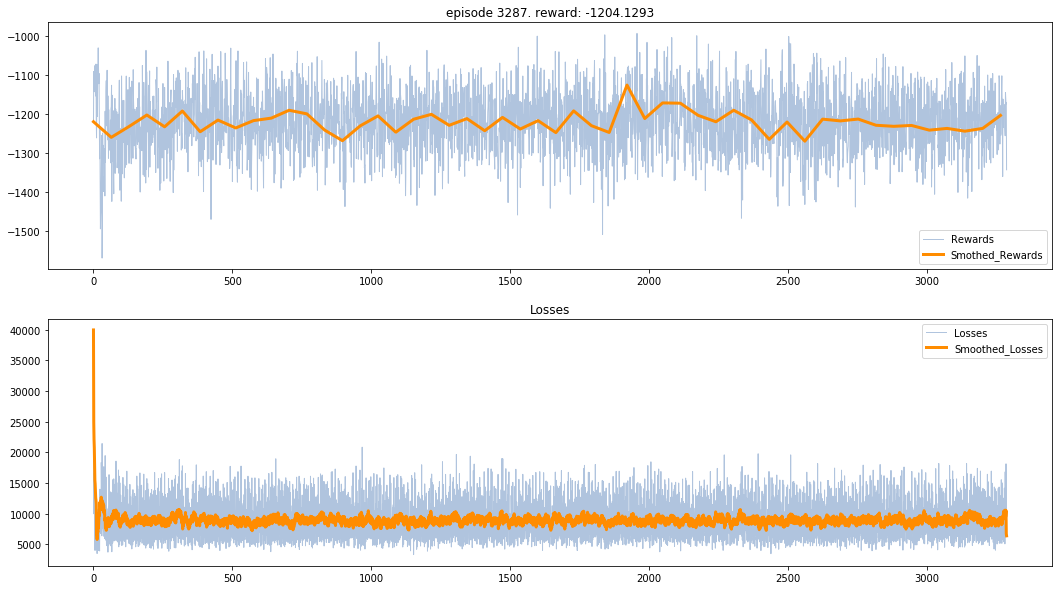

In [ ]:
test_rewards = []
loss_list = []
state = envs.reset()

for epoch in range(max_epoch):
    states, actions, rewards, masks, log_probs, values = [], [], [], [], [], []
    
    for _ in range(num_timesteps):
        dist, value = old_model(torch.FloatTensor(state).to(device))
        action = dist.sample()
        
        next_state, reward, done, _ = envs.step(action.cpu().numpy())
        
        states.append(torch.FloatTensor(state).to(device))
        actions.append(action)
        rewards.append(torch.FloatTensor(reward).unsqueeze(1).to(device))
        masks.append(torch.FloatTensor(1 - done).unsqueeze(1).to(device))
        log_probs.append(dist.log_prob(action))
        values.append(value)
        
        state = next_state
        
    _, next_value = model(torch.FloatTensor(next_state).to(device))
    advantages, td_target_list = gae_compute(next_value, rewards, masks, values)
    loss = ppo_train(torch.cat(states),torch.cat(actions), torch.cat(log_probs).detach(), 
                     torch.cat(advantages).detach(), torch.cat(td_target_list).detach())
    loss_list.append(loss)
    
    if epoch % 1 == 0:
        test_reward = np.mean([test_env() for _ in range(10)])
        test_rewards.append(test_reward)
        plot(epoch + 1, test_rewards, loss_list)
#         soft = lambda loss : np.mean(loss[-100:]) if len(loss)>=100 else np.mean(loss)
#         writer.add_scalar("Test_Rewards", np.array(soft(test_rewards)), epoch)
#         writer.add_scalar("Value_Losses", np.array(soft(loss_list)), epoch)

In [ ]:
from IPython import display

env = gym.make(env_name)
state_1 = env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(1000):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    
    prob, value = old_model(torch.FloatTensor(state_1).reshape(1,-1).to(device))
    action = prob.sample().cpu().numpy()
    next_state, _, done, _ = env.step(action)
    if done: 
        state_1 = env.reset()
    state_1 = next_state

## PPO Baselines:
<img src="../assets/PPO_baseline.png"></img>
### Test_Rewards:
<img src="../assets/PPO_Test_Rewards.png" width=100%></img>
### Value_Losses:
<img src="../assets/PPO_Value_Losses.png"></img>